In [1]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.nn import functional as F

import math

torch.manual_seed(904572)

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [3]:
max_steps = 5000
eval_interval = 500
eval_iters = 200
learning_rate = 1e-3
block_size = 8

In [4]:
!wget https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt

--2024-05-12 14:59:24--  https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1115394 (1.1M) [text/plain]
Saving to: ‘input.txt.4’

input.txt.4         100%[===================>]   1.06M  4.87MB/s    in 0.2s    

2024-05-12 14:59:25 (4.87 MB/s) - ‘input.txt.4’ saved [1115394/1115394]



In [5]:
with open("input.txt", "r", encoding="utf-8") as f:
    text = f.read()

In [6]:
print(len(text))

1115394


In [7]:
print(text[:1000])

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?

All:
Resolved. resolved.

First Citizen:
First, you know Caius Marcius is chief enemy to the people.

All:
We know't, we know't.

First Citizen:
Let us kill him, and we'll have corn at our own price.
Is't a verdict?

All:
No more talking on't; let it be done: away, away!

Second Citizen:
One word, good citizens.

First Citizen:
We are accounted poor citizens, the patricians good.
What authority surfeits on would relieve us: if they
would yield us but the superfluity, while it were
wholesome, we might guess they relieved us humanely;
but they think we are too dear: the leanness that
afflicts us, the object of our misery, is as an
inventory to particularise their abundance; our
sufferance is a gain to them Let us revenge this with
our pikes, ere we become rakes: for the gods know I
speak this in hunger for bread, not in thirst for revenge.



In [8]:
chars = sorted(list(set(text)))
vocab_size = len(chars)
print(f"Number of characters: {vocab_size}")
print(f"Characters: {''.join(chars)}")

Number of characters: 65
Characters: 
 !$&',-.3:;?ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz


In [9]:
stoi = {char:i for i, char in enumerate(chars)}
itos = {i:char for i, char in enumerate(chars)}
encode = lambda s: [stoi[c] for c in s]
decode = lambda l: "".join([itos[i] for i in l])

In [10]:
stoi

{'\n': 0,
 ' ': 1,
 '!': 2,
 '$': 3,
 '&': 4,
 "'": 5,
 ',': 6,
 '-': 7,
 '.': 8,
 '3': 9,
 ':': 10,
 ';': 11,
 '?': 12,
 'A': 13,
 'B': 14,
 'C': 15,
 'D': 16,
 'E': 17,
 'F': 18,
 'G': 19,
 'H': 20,
 'I': 21,
 'J': 22,
 'K': 23,
 'L': 24,
 'M': 25,
 'N': 26,
 'O': 27,
 'P': 28,
 'Q': 29,
 'R': 30,
 'S': 31,
 'T': 32,
 'U': 33,
 'V': 34,
 'W': 35,
 'X': 36,
 'Y': 37,
 'Z': 38,
 'a': 39,
 'b': 40,
 'c': 41,
 'd': 42,
 'e': 43,
 'f': 44,
 'g': 45,
 'h': 46,
 'i': 47,
 'j': 48,
 'k': 49,
 'l': 50,
 'm': 51,
 'n': 52,
 'o': 53,
 'p': 54,
 'q': 55,
 'r': 56,
 's': 57,
 't': 58,
 'u': 59,
 'v': 60,
 'w': 61,
 'x': 62,
 'y': 63,
 'z': 64}

In [11]:
itos

{0: '\n',
 1: ' ',
 2: '!',
 3: '$',
 4: '&',
 5: "'",
 6: ',',
 7: '-',
 8: '.',
 9: '3',
 10: ':',
 11: ';',
 12: '?',
 13: 'A',
 14: 'B',
 15: 'C',
 16: 'D',
 17: 'E',
 18: 'F',
 19: 'G',
 20: 'H',
 21: 'I',
 22: 'J',
 23: 'K',
 24: 'L',
 25: 'M',
 26: 'N',
 27: 'O',
 28: 'P',
 29: 'Q',
 30: 'R',
 31: 'S',
 32: 'T',
 33: 'U',
 34: 'V',
 35: 'W',
 36: 'X',
 37: 'Y',
 38: 'Z',
 39: 'a',
 40: 'b',
 41: 'c',
 42: 'd',
 43: 'e',
 44: 'f',
 45: 'g',
 46: 'h',
 47: 'i',
 48: 'j',
 49: 'k',
 50: 'l',
 51: 'm',
 52: 'n',
 53: 'o',
 54: 'p',
 55: 'q',
 56: 'r',
 57: 's',
 58: 't',
 59: 'u',
 60: 'v',
 61: 'w',
 62: 'x',
 63: 'y',
 64: 'z'}

In [12]:
encode("Hello, world")

[20, 43, 50, 50, 53, 6, 1, 61, 53, 56, 50, 42]

In [13]:
decode(encode("Hello, world"))

'Hello, world'

In [14]:
data = torch.tensor(encode(text), dtype=torch.long)

In [15]:
print(f"Data shape: {data.shape} | Data dtype: {data.dtype}")
print(data[:1000])

Data shape: torch.Size([1115394]) | Data dtype: torch.int64
tensor([18, 47, 56, 57, 58,  1, 15, 47, 58, 47, 64, 43, 52, 10,  0, 14, 43, 44,
        53, 56, 43,  1, 61, 43,  1, 54, 56, 53, 41, 43, 43, 42,  1, 39, 52, 63,
         1, 44, 59, 56, 58, 46, 43, 56,  6,  1, 46, 43, 39, 56,  1, 51, 43,  1,
        57, 54, 43, 39, 49,  8,  0,  0, 13, 50, 50, 10,  0, 31, 54, 43, 39, 49,
         6,  1, 57, 54, 43, 39, 49,  8,  0,  0, 18, 47, 56, 57, 58,  1, 15, 47,
        58, 47, 64, 43, 52, 10,  0, 37, 53, 59,  1, 39, 56, 43,  1, 39, 50, 50,
         1, 56, 43, 57, 53, 50, 60, 43, 42,  1, 56, 39, 58, 46, 43, 56,  1, 58,
        53,  1, 42, 47, 43,  1, 58, 46, 39, 52,  1, 58, 53,  1, 44, 39, 51, 47,
        57, 46, 12,  0,  0, 13, 50, 50, 10,  0, 30, 43, 57, 53, 50, 60, 43, 42,
         8,  1, 56, 43, 57, 53, 50, 60, 43, 42,  8,  0,  0, 18, 47, 56, 57, 58,
         1, 15, 47, 58, 47, 64, 43, 52, 10,  0, 18, 47, 56, 57, 58,  6,  1, 63,
        53, 59,  1, 49, 52, 53, 61,  1, 15, 39, 47, 59, 57, 

In [16]:
n = int(0.9*len(data))
train_data = data[:n]
val_data = data[n:]

In [17]:
block_size = 8

In [18]:
train_data[:block_size+1]

tensor([18, 47, 56, 57, 58,  1, 15, 47, 58])

In [19]:
x = train_data[:block_size]
y = train_data[1:block_size+1]
for t in range(block_size):
    context = x[:t+1]
    target = y[t]
    print(f"when input is {context}, the target is {target}")

when input is tensor([18]), the target is 47
when input is tensor([18, 47]), the target is 56
when input is tensor([18, 47, 56]), the target is 57
when input is tensor([18, 47, 56, 57]), the target is 58
when input is tensor([18, 47, 56, 57, 58]), the target is 1
when input is tensor([18, 47, 56, 57, 58,  1]), the target is 15
when input is tensor([18, 47, 56, 57, 58,  1, 15]), the target is 47
when input is tensor([18, 47, 56, 57, 58,  1, 15, 47]), the target is 58


In [20]:
batch_size = 4
block_size = 8

In [21]:
def get_batch(split):
    data = train_data if split == "train" else val_data
    ix = torch.randint(len(data)-block_size, (batch_size,))
    x = torch.stack([data[i:i+block_size] for i in ix])
    y = torch.stack([data[i+1:i+block_size+1] for i in ix])
    x, y = x.to(device), y.to(device)

    return x, y

In [22]:
xb, yb = get_batch("train")

In [23]:
print(f"input shape: {xb.shape}")
print(f"input: {xb}")
print(f"target shape: {yb.shape}")
print(f"target: {yb}")

input shape: torch.Size([4, 8])
input: tensor([[30, 10,  0, 13, 52, 53, 52,  2],
        [45, 52, 51, 43, 52, 58, 57,  0],
        [ 6,  1, 39, 52, 42,  1, 47, 52],
        [63, 53, 59, 56,  1, 46, 47, 45]], device='cuda:0')
target shape: torch.Size([4, 8])
target: tensor([[10,  0, 13, 52, 53, 52,  2,  0],
        [52, 51, 43, 52, 58, 57,  0, 21],
        [ 1, 39, 52, 42,  1, 47, 52,  1],
        [53, 59, 56,  1, 46, 47, 45, 46]], device='cuda:0')


In [24]:
for b in range(batch_size):
    for t in range(block_size):
        context = xb[b, :t+1]
        target = yb[b, t]
        print(f"when input is {context}, the target is {target}")
    print("")

when input is tensor([30], device='cuda:0'), the target is 10
when input is tensor([30, 10], device='cuda:0'), the target is 0
when input is tensor([30, 10,  0], device='cuda:0'), the target is 13
when input is tensor([30, 10,  0, 13], device='cuda:0'), the target is 52
when input is tensor([30, 10,  0, 13, 52], device='cuda:0'), the target is 53
when input is tensor([30, 10,  0, 13, 52, 53], device='cuda:0'), the target is 52
when input is tensor([30, 10,  0, 13, 52, 53, 52], device='cuda:0'), the target is 2
when input is tensor([30, 10,  0, 13, 52, 53, 52,  2], device='cuda:0'), the target is 0

when input is tensor([45], device='cuda:0'), the target is 52
when input is tensor([45, 52], device='cuda:0'), the target is 51
when input is tensor([45, 52, 51], device='cuda:0'), the target is 43
when input is tensor([45, 52, 51, 43], device='cuda:0'), the target is 52
when input is tensor([45, 52, 51, 43, 52], device='cuda:0'), the target is 58
when input is tensor([45, 52, 51, 43, 52, 58

In [25]:
class BigramLanguageModel(nn.Module):
    def __init__(self, vocab_size):
        super().__init__()
        self.token_embedding_table = nn.Embedding(vocab_size, vocab_size)

    def forward(self, idx, targets=None):
        logits = self.token_embedding_table(idx)
        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets)

        return logits, loss

    def generate(self, idx, max_new_tokens):
        for _ in range(max_new_tokens):
            logits, loss = self(idx)
            logits = logits[:, -1, :]
            probs = F.softmax(logits, dim=-1)
            idx_next = torch.multinomial(probs, num_samples=1)
            idx = torch.cat((idx, idx_next), dim=1)

        return idx

In [26]:
@torch.no_grad()
def estimate_loss(model):
    out = {}
    model.eval()
    for split in ["train", "val"]:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            X, Y = get_batch(split)
            logits, loss = model(X, Y)
            losses[k] = loss.item()
        out[split] = losses.mean()
    model.train()

    return out

In [27]:
blm = BigramLanguageModel(vocab_size).to(device)
logits, loss = blm(xb, yb)
print(logits.shape)
print(loss)

torch.Size([32, 65])
tensor(4.5921, device='cuda:0', grad_fn=<NllLossBackward0>)


In [28]:
-math.log(1/65)

4.174387269895637

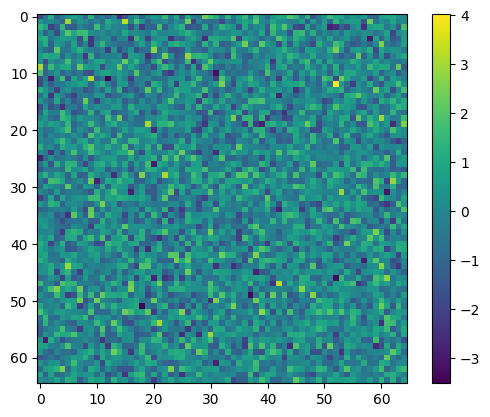

In [29]:
init_emb = blm.token_embedding_table.weight.cpu().detach().numpy()
plt.imshow(init_emb, cmap="viridis")
plt.colorbar()
plt.show()

In [30]:
idx = torch.zeros((1, 1), dtype=torch.long, device=device)
print(decode(blm.generate(idx, max_new_tokens=100)[0].tolist()))


OeH'ITE I?nfvFvrRNsDDg&,DotGiDidNGGgBRgFvGiX?yfaX?za'SjXqu$LrqZJ.'vJSRLyt'XqfB-PgB&O!up HF&?nafFDXEs


In [31]:
optimizer = torch.optim.AdamW(blm.parameters(), lr=learning_rate)

In [32]:
batch_size = 32
for step in range(max_steps):
    if step % eval_interval == 0:
        losses = estimate_loss(blm)
        print(f"step: {step} | train loss: {losses['train']:.4f} | val loss: {losses['val']:.4f}")
    xb, yb = get_batch("train")
    logits, loss = blm(xb, yb)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

step: 0 | train loss: 4.7238 | val loss: 4.7146
step: 500 | train loss: 4.1784 | val loss: 4.1733
step: 1000 | train loss: 3.7316 | val loss: 3.7424
step: 1500 | train loss: 3.4063 | val loss: 3.4018
step: 2000 | train loss: 3.1471 | val loss: 3.1474
step: 2500 | train loss: 2.9565 | val loss: 2.9652
step: 3000 | train loss: 2.8294 | val loss: 2.8415
step: 3500 | train loss: 2.7244 | val loss: 2.7378
step: 4000 | train loss: 2.6522 | val loss: 2.6718
step: 4500 | train loss: 2.5971 | val loss: 2.6186


In [33]:
idx = torch.zeros((1, 1), dtype=torch.long, device=device)
print(decode(blm.generate(idx, max_new_tokens=100)[0].tolist()))


ANONC's win t wGLes DY u mukWar arthe.Anesf KII;l tY! iso-tedF-cO hy oury avepocused blENLELY:

We? 


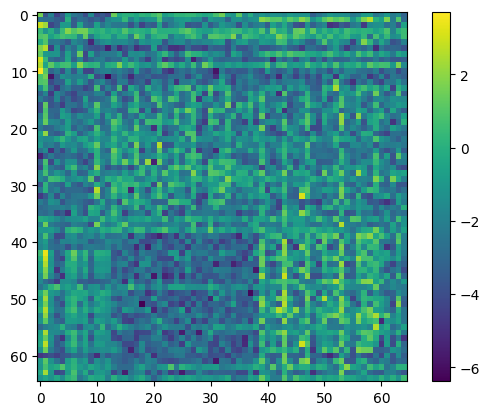

In [34]:
plt.imshow(blm.token_embedding_table.weight.cpu().detach().numpy(), cmap="viridis")
plt.colorbar()
plt.show()

In [35]:
batch_size = 64
block_size = 256
learning_rate = 3e-4
n_embd = 384
n_layer = 6
n_head = 6
dropout = 0.2

In [36]:
class Head(nn.Module):
    def __init__(self, head_size):
        super().__init__()
        self.key = nn.Linear(n_embd, head_size, bias=False)
        self.query = nn.Linear(n_embd, head_size, bias=False)
        self.value = nn.Linear(n_embd, head_size, bias=False)
        self.register_buffer("tril", torch.tril(torch.ones(block_size, block_size)))
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        B, T, C = x.shape
        k = self.key(x)
        q = self.query(x)
        
        wei = q @ k.transpose(-2, -1) * k.shape[-1]**-0.5
        wei = wei.masked_fill(self.tril[:T, :T] == 0, float("-inf"))
        wei = F.softmax(wei, dim=-1)
        wei = self.dropout(wei)

        v = self.value(x)
        out = wei @ v

        return out

In [37]:
class MultiHeadAttention(nn.Module):
    def __init__(self, num_heads, head_size):
        super().__init__()
        self.heads = nn.ModuleList([Head(head_size) for _ in range(num_heads)])
        self.proj = nn.Linear(head_size * num_heads, n_embd)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        out = torch.cat([h(x) for h in self.heads], dim=-1)
        out = self.dropout(self.proj(out))

        return out

In [38]:
class FeedForward(nn.Module):
    def __init__(self, n_embd):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_embd, 4 * n_embd),
            nn.ReLU(),
            nn.Linear(4 * n_embd, n_embd),
            nn.Dropout(dropout),
        )

    def forward(self, x):
        return self.net(x)

In [39]:
class Block(nn.Module):
    def __init__(self, n_embd, n_head):
        super().__init__()
        head_size = n_embd // n_head
        self.sa = MultiHeadAttention(n_head, head_size)
        self.ffwd = FeedForward(n_embd)
        self.ln1 = nn.LayerNorm(n_embd)
        self.ln2 = nn.LayerNorm(n_embd)

    def forward(self, x):
        x = x + self.sa(self.ln1(x))
        x = x + self.ffwd(self.ln2(x))

        return x

In [40]:
class GPTLanguageModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.token_embedding_table = nn.Embedding(vocab_size, n_embd)
        self.position_embedding_table = nn.Embedding(block_size, n_embd)
        self.blocks = nn.Sequential(*[Block(n_embd, n_head=n_head) for _ in range(n_layer)])
        self.ln_f = nn.LayerNorm(n_embd)
        self.lm_head = nn.Linear(n_embd, vocab_size)

    def forward(self, idx, targets=None):
        B, T = idx.shape
        
        tok_emb = self.token_embedding_table(idx)
        pos_emb = self.position_embedding_table(torch.arange(T, device=device))
        x = tok_emb + pos_emb
        x = self.blocks(x)
        x = self.ln_f(x)
        logits = self.lm_head(x)
        if targets is None:
            loss = None
        else:
            logits = logits.view(B*T, -1)
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets)

        return logits, loss

    def generate(self, idx, max_new_tokens):
        for _ in range(max_new_tokens):
            idx_cond = idx[:, -block_size:]
            logits, loss = self(idx_cond)
            logits = logits[:, -1, :]
            probs = F.softmax(logits, dim=-1)
            idx_next = torch.multinomial(probs, num_samples=1)
            idx = torch.cat((idx, idx_next), dim=1)

        return idx

In [41]:
model = GPTLanguageModel().to(device)

In [42]:
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

In [43]:
for step in range(max_steps):
    if step % eval_interval == 0:
        losses = estimate_loss(blm)
        print(f"step: {step} | train loss: {losses['train']:.4f} | val loss: {losses['val']:.4f}")
    xb, yb = get_batch("train")
    logits, loss = model(xb, yb)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

step: 0 | train loss: 2.5667 | val loss: 2.5809


KeyboardInterrupt: 

In [ ]:
idx = torch.zeros((1, 1), dtype=torch.long, device=device)
print(decode(model.generate(idx, max_new_tokens=1000)[0].tolist()))


Parn we may suchnot:
The myset,
Tifke: to to by.
On agarend ental in't it thind?
.xerems,
To dody be frodyellf
Maty that not chomplens,
And cailk
The remain, it may:
Is 'tels methy maid, greact to to seble good yough not in shig in But Haw is the death good
With full,
And stay pooplent is bone iffed?
Now?

BULHENTEON:
Pome is hoghat him athould wincotant.

Jour vest you thiw; the .

Rut or they not the good there fict,
That seest it.

Puch rought must tire neite have much tient.
Trre of that your seet heard,

cranty off in artie'd'd feaken you dard. Wighis some tentravoan fail, bee? 'tay have pate you goodes,
To out mothat, yought the cay hear?
do my of cannotite-
it that swas ball lovice:
All him graht heme of
Int the in'tles, was spith a ic be Pray somy mady my soune do noche,
That ave for yet thrend and the give-stinks to stiate: woulh son sirn my soreess with lookes are to kill bow wordss: I and with bleposet
Your though,
Whicnoult:
Thed?
so prushem:
I staid then dood-tant
meaken'